In [1]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("Polynomials")
print(VERSION)

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [

    Fetching: [===================>                     

    Fetching: [

    Fetching: [=====================================>   

Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`


1.4.1

  [f27b6e38] + Polynomials v0.6.1
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


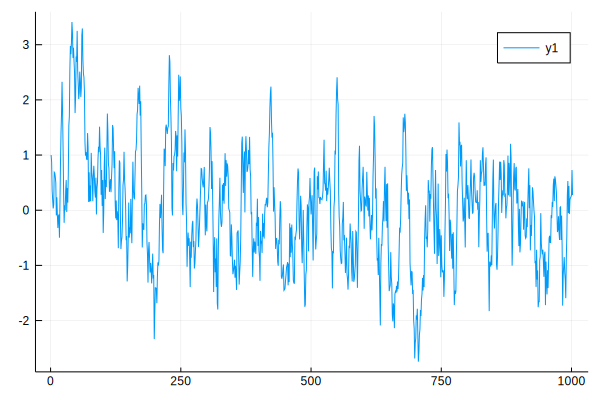

In [2]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,100.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260


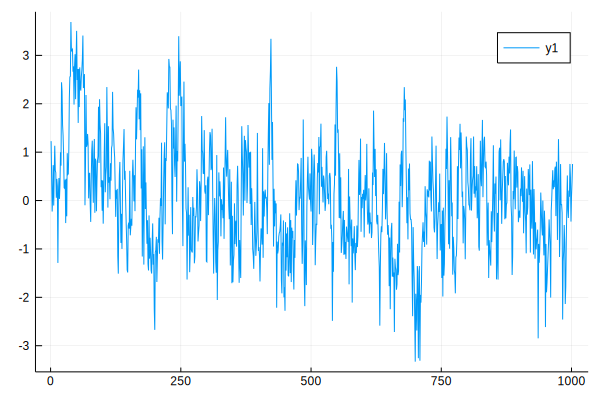

In [3]:
using Distributions, Random
ou_data = sol.u
noise = rand(Normal(0,0.5), length(ou_data))
data = ou_data.+noise
plot(data)

In [4]:
using Polynomials
# function to calculate A and B from the dataset
function OUanalytic(data)
    N = length(data)
    data1sq = data[1]^2
    dataNsq = data[end]^2
    datasq = sum(data[2:end-1].^2)
    datacorr = sum(data[1:end-1].*data[2:end])
    B_coef = Poly([N*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       (2.0-N)*datacorr,     
       (N-1)*datasq])
    B=roots(B_coef)[end-1]
    Q=(data1sq+dataNsq)/(1-B^2)
    Q=Q+datasq*(1+B^2)/(1-B^2)
    Q=Q-datacorr*2*B/(1-B^2)
    A = Q/N
    P2A = -N/A^2/2
    Btmp = B^2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B^4*(N-1))*datasq - 2*B*(1+B^2+2*N)*datacorr
    P2B = -tmp/((1-B^2)^2*(data1sq+dataNsq + (1+B^2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B^2)
    dA = sqrt(-P2B/(P2A*P2B-PAB^2))
    dB = sqrt(-P2A/(P2A*P2B-PAB^2))
    return A,dA,B,dB
end

function OUresult(data,deltat)
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/log(B)
    dtau = deltat*dB/B/log(B)^2
    return A,dA,tau,dtau
end

┌ Info: Precompiling Polynomials [f27b6e38-b328-58d1-80ce-0feddd5e7a45]
└ @ Base loading.jl:1260


OUresult (generic function with 1 method)

In [5]:
OUanalytic(ou_data)

(1.0027066966210683, 0.13387842714783163, 0.8948698358804016, 0.014018508660928762)

In [1]:
# function to multiply two Gaussians
function mul_gauss(mu1,mu2,sigma1,sigma2)
    mu = (mu1*sigma2^2+mu2*sigma1^2)/(sigma1^2+sigma2^2)
    sigma = sqrt(sigma1^2*sigma2^2/(sigma1^2+sigma2^2))
    return mu,sigma
end

# function to convolute two Gaussians
function con_gauss(mu1,mu2,sigma1,sigma2)
    mu = mu1 + mu2
    sigma = sqrt(sigma1^2+sigma2^2)
    return mu,sigma
end

# function to calculate latent variable x from y given sigma,A,B
function alpha(y,sigma,A,B)
    N = length(y)
    x = zeros(N)
    x[1] = y[1]*sigma^2/(sigma^2+A)
    for i=2:N
        x[i] = (y[i]*sigma^2+B*x[i-1]*A*(1-B^2))/(sigma^2+A*(1-B^2))
    end
    return x
end

alpha (generic function with 1 method)

In [21]:
sigma = 0.5
A=1
B=0.9
sigsq_data = std(data)^2
print("sigma square data ",sigsq_data,"\n")
for i=1:1000
    print("sigma: ",sigma," A: ",A," B: ",B,"\n")
    x = latentx(data,sigma,A,B)
    A,dA,B,dB = OUanalytic(x)
    if A>sigsq_data
        sigma = 0.0
    else
        sigma = sqrt(sigsq_data-A)
    end
end

sigma square data 1.1659162136952517
sigma: 0.5 A: 1 B: 0.9
sigma: 0.598749275570973 A: 0.8074155186984867 B: 0.883922929813406
sigma: 0.5307489795975031 A: 0.8842217343514609 B: 0.8484687834897762
sigma: 0.6643964528972235 A: 0.7244935670728392 B: 0.8867624093291933
sigma: 0.46899852394932107 A: 0.9459565982286098 B: 0.8228729326539708
sigma: 0.7720638108940064 A: 0.5698336856030755 B: 0.9119355551742673
sigma: 0.33552817192122175 A: 1.0533370595424547 B: 0.7735258654029844
sigma: 0.9654012941456921 A: 0.23391655495707464 B: 0.9454976247878563
sigma: 0.14080887961002336 A: 1.1460890731182216 B: 0.7167944345953966
sigma: 1.0755045178722829 A: 0.009206245731559993 B: 0.9618919900994303
sigma: 0.0 A: 1.1664285366975606 B: 0.7022830688226726


BoundsError: BoundsError: attempt to access 0-element Array{Float64,1} at index [-1]

In [11]:
plot(x)
plot!(sol.u)

UndefVarError: UndefVarError: x not defined

In [9]:
plot(data.-x)
plot!(noise)

UndefVarError: UndefVarError: x not defined

In [14]:
print(1+0.5^2)

1.25